# Facility location problem

This notebook illustrates Example 20 from Chapter 3 of the textbook Hands-On Mathematical Optimization with Python, Cambridge University Press, 2024.

For details about these models and more information we refer to the book.

Also notice that at the end of Chapter 3 you may find a number of exercises that show that versions of this problem aiming at maximizing the importance of the customers served, when facing constraints that limit the possibility of serving all, leads to even more striking evidence for the importance of selecting the right model: it can offer large factors of speedup in solving the relevant instances!


## Preamble: Install Pyomo and solvers

The following cell sets and verifies a Pyomo installation and the solver CBC. If run on Google Colab, the cell installs Pyomo and the CBC solver, while, if run elsewhere, it assumes they all have been previously installed.

In [9]:
import sys

if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    !apt-get install -y -qq coinor-cbc    

## Problem description

Consider the problem of a supplier facing the task of fulfilling specific customer demands with minimal costs while simultaneously deciding how many facilities to build and where. In terms of data, we are given a set $I$ of customers, a set $J$ of possible locations, the cost $c_j$ of building facility $j$, and the cost $h_{ij}$ incurred to satisfy the demands of customer $i$ at facility $j$.

In this notebook we will formulate two equivalent models for this problem and compare their performance.

## First MILO formulation

Introduce two sets of binary variables,

$$
\begin{equation*}
    x_j:=
    \begin{cases}
    1 & \text{ if facility $j$ is built,}\\
    0 & \text{ otherwise,}
    \end{cases}
\end{equation*}
$$

and

$$
\begin{equation*}
    y_{ij}:=
    \begin{cases}
    1 & \text{ if customer $i$ is served at facility $j$,}\\
    0 & \text{ otherwise.}
    \end{cases}
\end{equation*}
$$

The resulting MILO is

$$
\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \text{s.t.} \quad & \sum_{j \in J} y_{ij} =1 \qquad \forall \, i \in I & \text{(every customer is served)}\\
    & y_{ij} \leq x_{j} \qquad \forall \, i\in I, \, \forall \, j \in J & \text{(facility built before use)}\\
    & x_j \in \{0,1\} \qquad \forall \, i\in I\\
    & y_{ij} \in \{0,1\} \qquad \forall \, i\in I, \, \forall \, j \in J.
\end{align*}
$$

## Second MILO formulation

Let $n=|J|$ be the number of possible facility locations and $m=|I|$ the number of customers. Note that, since $\sum_j y_{ij} =1$ for every $i \in I$, we can replace the $n \times m$ constraints $y_{ij} \leq x_j$ by only $n$ constraints, namely

$$
\begin{equation*}
    \sum_i y_{ij} \leq n x_j \qquad \forall \, j \in J.
\end{equation*}
$$

The second MILO is

$$
\begin{align*}
    \min \quad & \sum_{j \in J} c_j x_j + \sum_{i \in I} \sum_{j \in J} h_{ij} y_{ij} \\
    \text{s.t.} \quad & \sum_{j \in J} y_{ij} =1 \qquad \forall \, i \in I & \text{(every customer is served)}\\
    & \sum_i y_{ij} \leq n x_j \qquad \forall \, j \in J & \text{(facility built before use)}\\
    & x_j \in \{0,1\} \qquad \forall \, i\in I\\
    & y_{ij} \in \{0,1\} \qquad \forall \, i\in I, \, \forall \, j \in J.
\end{align*}
$$

This approach leads to a more concise mathematical formulation of the model. However, it may not be a good idea if we want to solve the problem using its linear relaxation. Indeed, by reducing the number of constraints, we inadvertently made the feasible region of the relaxation larger and less tight around the feasible integer points. This fact becomes clearly evident in the increased run-time required to solve the optimization problem when working with these weaker constraints, see figures below.

Instead of defining two separate Pyomo models, we will define a single common model and then add either the strong or weaker formulation of the "facility built before use" constraint.

In [10]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from time import perf_counter as pc
from tqdm.notebook import tqdm
import subprocess

# Solvers and options

In [11]:
def ListAvailableSolvers():
    shell_command = "pyomo help --solvers"
    output = subprocess.check_output(shell_command, shell=True).decode()
    return [
        line.strip()[1:]
        for line in output.split()
        if line.strip().startswith("+") and not line.strip().endswith(")")
    ]


def GetSolverName(solver):
    try:
        return solver.name
    except:
        return "appsi_highs"


def SwitchCutsOff(solver):
    solver_name = GetSolverName(solver)
    if "cbc" in solver_name:
        solver.options["Cuts"] = "off"
    elif "cplex" in solver_name:
        solver.options["mip_cuts_bqp"] = -1
        solver.options["mip_cuts_cliques"] = -1
        solver.options["mip_cuts_covers"] = -1
        solver.options["mip_cuts_disjunctive"] = -1
        solver.options["mip_cuts_flowcovers"] = -1
        solver.options["mip_cuts_pathcut"] = -1
        solver.options["mip_cuts_gomory"] = -1
        solver.options["mip_cuts_gubcovers"] = -1
        solver.options["mip_cuts_implied"] = -1
        solver.options["mip_cuts_localimplied"] = -1
        solver.options["mip_cuts_liftproj"] = -1
        solver.options["mip_cuts_mircut"] = -1
        solver.options["mip_cuts_mcfcut"] = -1
        solver.options["mip_cuts_rlt"] = -1
        solver.options["mip_cuts_zerohalfcut"] = -1
    elif "gurobi" in solver_name:
        solver.options["Cuts"] = 0
    elif "highs" in solver_name:
        pass  # there is no way to do this, see
        # https://ergo-code.github.io/HiGHS/dev/options/definitions/
    elif "xpress" in solver_name:
        solver.options["CUTSTRATEGY"] = 0
    else:
        pass
    return solver


def SwitchPresolveOff(solver):
    solver_name = GetSolverName(solver)
    if "cbc" in solver_name:
        solver.options["Presolve"] = "off"
    elif "cplex" in solver_name:
        solver.options["preprocessing_presolve"] = 0
    elif "gurobi" in solver_name:
        solver.options["Presolve"] = 0
    elif "highs" in solver_name:
        solver.options["presolve"] = "off"
    elif "xpress" in solver_name:
        solver.options["PRESOLVE"] = 0
    else:
        pass
    return solver


def LimitSolveTime(solver, max_in_seconds):
    solver_name = GetSolverName(solver)
    if "cbc" in solver_name:
        solver.options["seconds"] = max_in_seconds
    elif "cplex" in solver_name:
        solver.options["timelimit"] = max_in_seconds
    elif "gurobi" in solver_name:
        solver.options["TimeLimit"] = max_in_seconds
    elif "highs" in solver_name:
        solver.options["time_limit"] = max_in_seconds
    elif "xpress" in solver_name:
        solver.options["MAXTIME"] = max_in_seconds
    else:
        pass
    return solver


def ClosureForMaxTime(max_in_seconds):
    return lambda solver: LimitSolveTime(solver, max_in_seconds)

In [12]:
def compose(*functions):
    def composed(*args, **kwargs):
        result = args[0]
        for func in functions:
            result = func(result)
        return result

    return composed

In [13]:
initial_solvers = ListAvailableSolvers()
initial_solvers

['appsi_gurobi',
 'appsi_highs',
 'cbc',
 'gdpopt',
 'gdpopt.gloa',
 'gdpopt.lbb',
 'gdpopt.loa',
 'gdpopt.ric',
 'gurobi',
 'gurobi_direct',
 'gurobi_persistent',
 'ipopt',
 'mindtpy',
 'mindtpy.ecp',
 'mindtpy.fp',
 'mindtpy.goa',
 'mindtpy.oa',
 'mosek',
 'mosek_direct',
 'mosek_persistent',
 'mpec_minlp',
 'mpec_nlp',
 'multistart',
 'scipy.fsolve',
 'scipy.newton',
 'scipy.root',
 'scipy.secant-newton',
 'trustregion']

# The models

In [14]:
def FacilityLocationCommon(installation, service):
    model = pyo.ConcreteModel("Facility location")
    model.facilities = pyo.Set(initialize=range(len(installation)))
    model.customers = pyo.Set(initialize=range(len(service)))

    model.x = pyo.Var(model.facilities, within=pyo.Binary)
    model.y = pyo.Var(model.customers, model.facilities, within=pyo.Binary)

    @model.Objective(sense=pyo.minimize)
    def obj(model):
        return sum(installation[j] * model.x[j] for j in model.facilities) + sum(
            service[i][j] * model.y[i, j]
            for i in model.customers
            for j in model.facilities
        )

    @model.Constraint(model.customers)
    def ChooseOneFacility(model, i):
        return sum(model.y[i, j] for j in model.facilities) == 1

    return model


def FacilityLocationWeak(installation, service):
    model = FacilityLocationCommon(installation, service)
    model.name += " weak model"

    @model.Constraint(model.facilities)
    def ServeIfOpen(model, j):
        return (
            sum(model.y[i, j] for i in model.customers)
            <= len(model.customers) * model.x[j]
        )

    return model


def FacilityLocationStrong(installation, service):
    model = FacilityLocationCommon(installation, service)
    model.name += " strong model"

    @model.Constraint(model.customers, model.facilities)
    def ServeIfOpen(model, i, j):
        return model.y[i, j] <= model.x[j]

    return model


def GetSolution(model):
    X = [model.x[j]() > 0.5 for j in model.facilities]
    Y = [[model.y[i, j]() > 0.5 for j in model.facilities] for i in model.customers]
    return X, Y, model.obj()

We introduce functions to generate random instances for the problem and to then visualize the optimal solution.

In [15]:
def GenerateFacilityLocationInstance(nofFacilities, nofCustumers):
    facilities = range(nofFacilities)
    customers = range(nofCustumers)
    xC = np.random.randint(0, 100, nofCustumers)
    yC = np.random.randint(0, 100, nofCustumers)
    xF = np.random.randint(0, 100, nofFacilities)
    yF = np.random.randint(0, 100, nofFacilities)

    installation = np.random.randint(1000, 2000, nofFacilities)

    dist = lambda i, j: ((xC[i] - xF[j]) ** 2 + (yC[i] - yF[j]) ** 2)

    service = [[dist(i, j) for j in facilities] for i in customers]

    return installation, service, xC, yC, xF, yF


def ShowFacilityLocation(xC, yC, xF, yF, X=[], Y=[], value=None, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    [
        ax.plot([xC[i], xF[j]], [yC[i], yF[j]], "g-")
        for j in range(len(X))
        if X[j]
        for i in range(len(Y))
        if Y[i][j]
    ]
    ax.plot(xC, yC, "o")
    ax.plot(xF, yF, "s")
    if title:
        ax.set_title(title)
    elif value:
        ax.set_title(f"Optimal value: {value}")

We then generate an instance of the problem with 10 facilities and 100 customers and initialize both a strong and a weak Pyomo models.

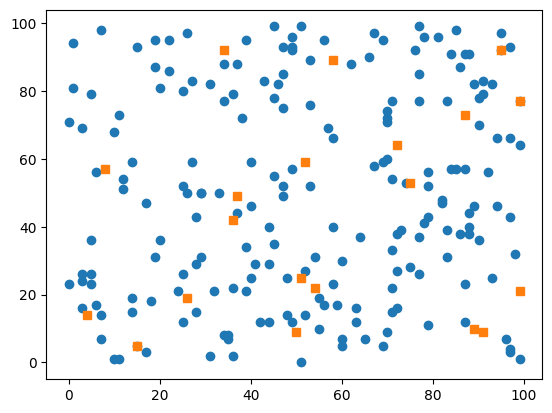

In [16]:
np.random.seed(2023)

installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(20, 200)
ShowFacilityLocation(xC, yC, xF, yF)

weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)

In [17]:
def Solve(solver, model):
    t = pc()
    _ = solver.solve(model)
    t = pc() - t
    X, Y, v = GetSolution(model)
    title = f"{model.name} solved by {GetSolverName(solver)} in {t:.2f} seconds {v:.0f}"
    return X, Y, v, title

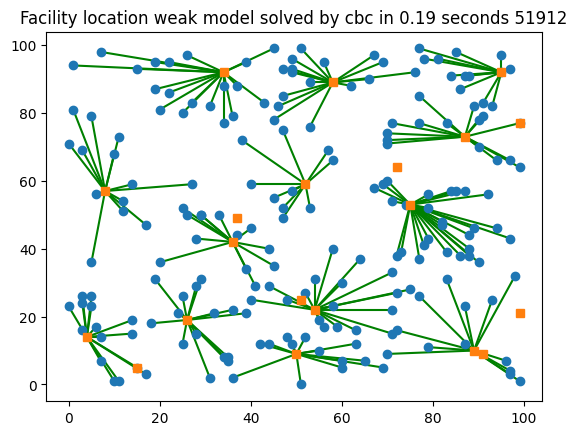

In [18]:
solver = pyo.SolverFactory("cbc")
ShowFacilityLocation(xC, yC, xF, yF, *Solve(solver, weak))

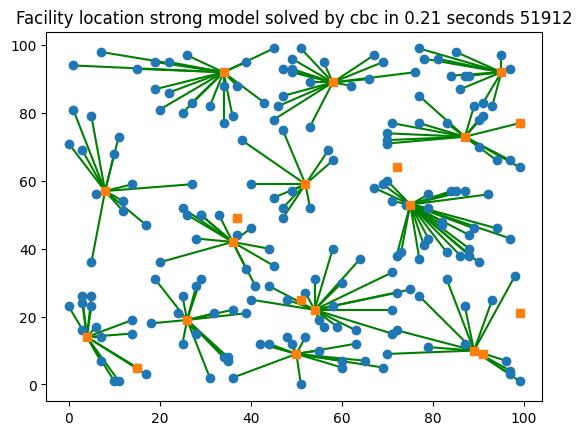

In [19]:
ShowFacilityLocation(xC, yC, xF, yF, *Solve(solver, strong))

However, this is not a proper performance comparison between the two model formulations, since under the hood `cbc` is already solving the instance in a clever way. The commercial solver `Gurobi` and the open-source solver `HiGHS` also have a similar feature. 

If run on Google Colab, the following cell installs three additional commercial solvers; if run elsewhere, it assumes they all have been previously installed.

In [20]:
if 'google.colab' in sys.modules:
    %pip install gurobipy >/dev/null 2>/dev/null
    %pip install cplex >/dev/null 2>/dev/null
    %pip install xpress >/dev/null 2>/dev/null

In [21]:
available_solvers = ListAvailableSolvers()
set(available_solvers) - set(initial_solvers)

set()

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


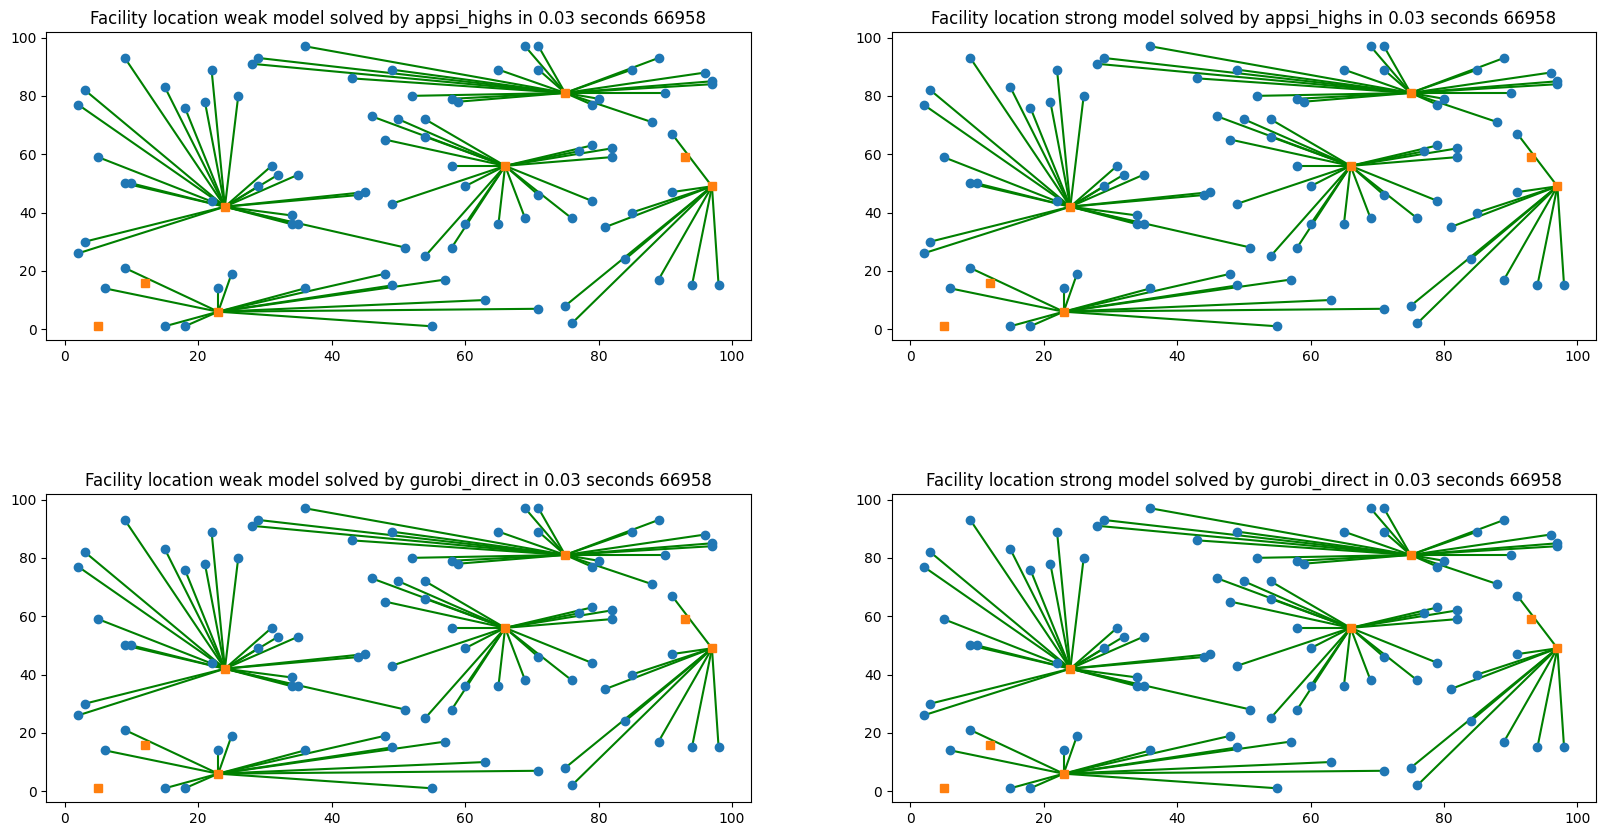

In [22]:
installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(8, 88)
weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)

solver_names = ["cplex_direct", "gurobi_direct", "xpress_direct", "appsi_highs"]
solver_names = sorted(set(solver_names) & set(ListAvailableSolvers()))

_, axs = plt.subplots(len(solver_names), 2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)

for i, solver_name in enumerate(solver_names):
    solver = SwitchCutsOff(pyo.SolverFactory(solver_name))
    ShowFacilityLocation(xC, yC, xF, yF, *Solve(solver, weak), ax=axs[i, 0])
    ShowFacilityLocation(xC, yC, xF, yF, *Solve(solver, strong), ax=axs[i, 1])

We now run a more extensive performance comparison considering increasingly larger instances of the problem. We will see that the strong formulation is consistently faster than the weak formulation.

In [29]:
def SolveInstances(dimensions, solvers, seed, modify=lambda s: s):
    np.random.seed(seed)
    model = {"weak": FacilityLocationWeak, "strong": FacilityLocationStrong}
    df = pd.DataFrame(
        index=dimensions,
        columns=[f"{s}_{m}" for s, m in it.product(solvers, model.keys())],
    )
    for n, m in tqdm(df.index):
        installation, service, *_ = GenerateFacilityLocationInstance(n, m)
        instance = {
            option: model[option](installation, service) for option in model.keys()
        }
        values = dict.fromkeys(solvers)
        for column in df.columns:
            solver = column[: column.rfind("_")]
            option = column[column.rfind("_") + 1 :]
            t = pc()
            modify(pyo.SolverFactory(solver)).solve(instance[option])
            df.at[(n, m), column] = pc() - t
            *_, v = GetSolution(instance[option])
            values[solver] = v
        if len(set(values.values())) > 1:
            print(values)
    return df

We solve instances with 10 to 100 facilities and 100 to 1000 customers. We then plot the run-time of the strong and weak formulations as a function of the number of facilities.

  0%|          | 0/9 [00:00<?, ?it/s]

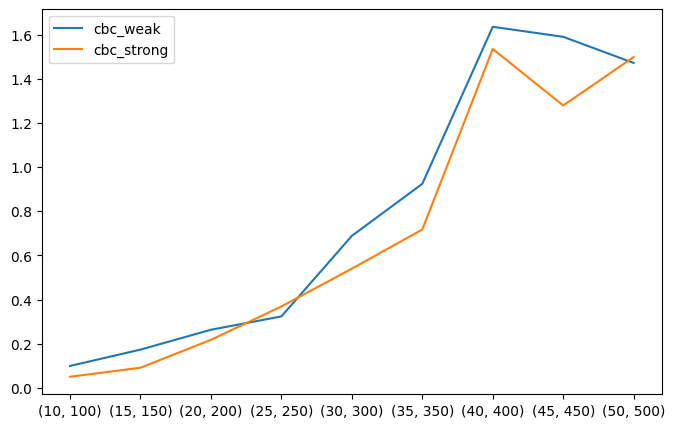

In [30]:
if "google.colab" in sys.modules:
    solvers = ["cbc"]
else:
    solvers = ["gurobi_direct", "cplex_direct"]
dimensions = [(n, 10 * n) for n in range(10, 51, 5)]

SolveInstances(dimensions, solvers, 2023).plot(figsize=(8, 5))
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

containing a solution
containing a solution
containing a solution
containing a solution
containing a solution
containing a solution


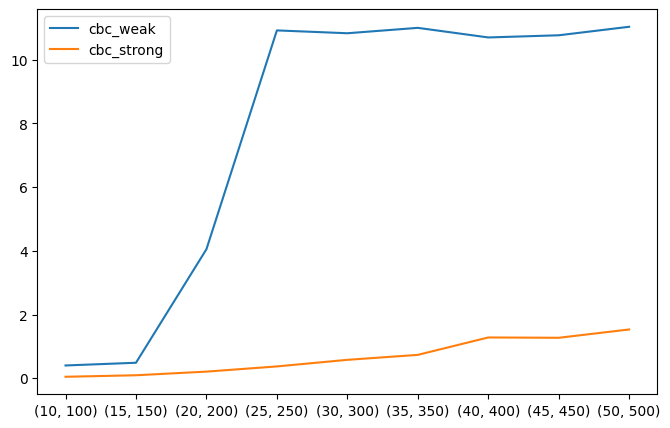

In [31]:
modify = compose(ClosureForMaxTime(10), SwitchCutsOff)
SolveInstances(dimensions, solvers, 2023, modify).plot(figsize=(8, 5))
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

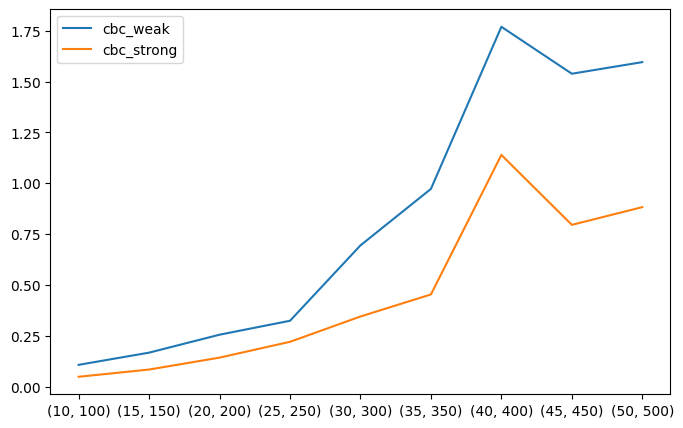

In [33]:
SolveInstances(dimensions, solvers, 2023, SwitchPresolveOff).plot(figsize=(8, 5))
plt.show()